# HNN EU Data Optimized

In [73]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.autograd import Variable
#from torchsummary import summary
#import torch.utils.data as Data

import optuna

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import scale
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import optuna

import copy
import itertools
import os
import time
import random
import math
import warnings
import sys

warnings.filterwarnings("ignore")

sys.path.append('../src/data/')

# Import HNN and tools functions
from HNN import HNN
import TrainHNN as TrainHNN
import DataProcessing as DataTools

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pd.set_option('display.max_columns', 2000) 

In [74]:
inflation = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='1.Inflation')
activity = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='2.Real activity')
external = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='3.External')
expectations = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='5.Expectations')
inflation

,HICPxEN_SA,HICPxENFOOD_SA
NaT,NaN,NaN
1999-03-31,89.14290,90.10781
1999-06-30,89.26107,90.24440
1999-09-30,89.45457,90.60880
1999-12-31,89.67210,90.66729
...,...,...
2017-03-31,117.96370,115.54440
2017-06-30,118.33870,116.00980
2017-09-30,118.70470,116.36170
2017-12-31,118.95130,116.36400


In [5]:
inflation = inflation.iloc[1:-1,:]
activity = activity.iloc[1:-1,:]
external = external.iloc[1:-1,:]
expectations = expectations.iloc[1:-1,:]
inflation

,HICPxEN_SA,HICPxENFOOD_SA
1999-03-31,89.14290,90.10781
1999-06-30,89.26107,90.24440
1999-09-30,89.45457,90.60880
1999-12-31,89.67210,90.66729
2000-03-31,89.88590,90.99102
...,...,...
2016-12-31,117.52750,115.29530
2017-03-31,117.96370,115.54440
2017-06-30,118.33870,116.00980
2017-09-30,118.70470,116.36170


In [6]:
# take the 1st difference
activity = activity.diff()
external = external.diff()
expectations = expectations.diff()
expectations

,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-06-30,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1999-09-30,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
1999-12-31,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
2000-03-31,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
2017-03-31,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
2017-06-30,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
2017-09-30,0.002263,-0.028594,-0.1,-0.4,0.1,0.0,-0.2,-0.2,0.1,0.1,0.112417,-0.085719,0.035703,0.041911,0.05,0.056208,0.106208,-0.069844,0.027941,0.061274,-0.014597,-0.051618,0.133385,0.110731,0.122038,-2.205786


In [7]:
inflation['Log_CPI'] = np.log(inflation['HICPxEN_SA'])

inflation['y'] = inflation['Log_CPI'].diff()

inflation

,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y
1999-03-31,89.14290,90.10781,4.490241,NaN
1999-06-30,89.26107,90.24440,4.491565,0.001325
1999-09-30,89.45457,90.60880,4.493731,0.002165
1999-12-31,89.67210,90.66729,4.496160,0.002429
2000-03-31,89.88590,90.99102,4.498541,0.002381
...,...,...,...,...
2016-12-31,117.52750,115.29530,4.766672,0.002216
2017-03-31,117.96370,115.54440,4.770377,0.003705
2017-06-30,118.33870,116.00980,4.773551,0.003174
2017-09-30,118.70470,116.36170,4.776639,0.003088


In [8]:
data = pd.concat([inflation, activity, external, expectations], axis=1, join='inner')
data

,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
1999-03-31,89.14290,90.10781,4.490241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-06-30,89.26107,90.24440,4.491565,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1999-09-30,89.45457,90.60880,4.493731,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
1999-12-31,89.67210,90.66729,4.496160,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
2000-03-31,89.88590,90.99102,4.498541,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,117.52750,115.29530,4.766672,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
2017-03-31,117.96370,115.54440,4.770377,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
2017-06-30,118.33870,116.00980,4.773551,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
2017-09-30,118.70470,116.36170,4.776639,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100,-0.198133,0.072477,-1.658358,4.333281,-3.410087,3.729492,-0.382453,4.170970,0.002263,-0.028594,-0.1,-0.4,0.1,0.0,-0.2,-0.2,0.1,0.1,0.112417,-0.085719,0.035703,0.041911,0.05,0.056208

In [9]:
# remove 1st row
data = data.iloc[1:,:]
data

,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
1999-06-30,89.26107,90.24440,4.491565,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1999-09-30,89.45457,90.60880,4.493731,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
1999-12-31,89.67210,90.66729,4.496160,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
2000-03-31,89.88590,90.99102,4.498541,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
2000-06-30,90.05369,91.06136,4.500406,0.001865,18749.009544,-0.23,0.364200,-0.201399,-0.020341,0.002490,0.0,0.144939,0.03575,0.3463,-0.028601,-0.262500,-0.053254,1.407823,-2.612603,1.954245,1.078176,1.196004,-2.612781,0.053530,0.069636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,0.069636,NaN,NaN,NaN,-5.567286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,117.52750,115.29530,4.766672,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
2017-03-31,117.96370,115.54440,4.770377,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
2017-06-30,118.33870,116.00980,4.773551,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
2017-09-30,118.70470,116.36170,4.776639,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100,-0.198133,0.072477,-1.658358,4

In [10]:
# rename index to date and make it a column
data = data.reset_index()
# rename index to date and make it the first column
data = data.rename(columns={'index':'date'})
data

,date,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
0,1999-06-30,89.26107,90.24440,4.491565,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1,1999-09-30,89.45457,90.60880,4.493731,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
2,1999-12-31,89.67210,90.66729,4.496160,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
3,2000-03-31,89.88590,90.99102,4.498541,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
4,2000-06-30,90.05369,91.06136,4.500406,0.001865,18749.009544,-0.23,0.364200,-0.201399,-0.020341,0.002490,0.0,0.144939,0.03575,0.3463,-0.028601,-0.262500,-0.053254,1.407823,-2.612603,1.954245,1.078176,1.196004,-2.612781,0.053530,0.069636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,0.069636,NaN,NaN,NaN,-5.567286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2016-12-31,117.52750,115.29530,4.766672,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
71,2017-03-31,117.96370,115.54440,4.770377,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
72,2017-06-30,118.33870,116.00980,4.773551,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
73,2017-09-30,118.70470,116.36170,4.776639,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100

In [11]:
# rename HICPxEN_SA to y
# data = data.rename(columns={'HICPxEN_SA':'y'})
# drop HICPxENFOOD_SA
data = data.drop(columns=['HICPxENFOOD_SA', 'HICPxEN_SA', 'Log_CPI'])
data

,date,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
0,1999-06-30,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1,1999-09-30,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
2,1999-12-31,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
3,2000-03-31,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
4,2000-06-30,0.001865,18749.009544,-0.23,0.364200,-0.201399,-0.020341,0.002490,0.0,0.144939,0.03575,0.3463,-0.028601,-0.262500,-0.053254,1.407823,-2.612603,1.954245,1.078176,1.196004,-2.612781,0.053530,0.069636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,0.069636,NaN,NaN,NaN,-5.567286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2016-12-31,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
71,2017-03-31,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
72,2017-06-30,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
73,2017-09-30,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100,-0.198133,0.072477,-1.658358,4.333281,-3.410087,3.729492,-0.382453,4.170970,0.002263,-0.028594,-0.1,-0.4,0.1,0.0,-0.2,-0.2,0.1,0.1,0.112417,-0.085719,0.035703,0.041911,0.05,0.056208,0.106208,-0.069844,0.027941,0.061274,-0.014597,-0.051618,0.133385,0.110731,0.122038,-2.205786


In [12]:
def create_lagged_columns_v2(df, num_lags):
    """
    Create specified number of lagged columns for each variable in the DataFrame.
    For the variable named 'y', do not add 'L0_' prefix and use a different naming convention for lags.

    Parameters:
    df (pd.DataFrame): The original DataFrame with macroeconomic data.
    num_lags (int): The number of lagged columns to create.

    Returns:
    pd.DataFrame: A DataFrame with the original and lagged columns.
    """

    lagged_data_chunks = []

    for col in df.columns:
        if col != 'date':
            # For the 'y' variable, handle lag creation and naming differently
            if col == 'y':
                for lag in range(1, num_lags + 1):
                    lagged_data_chunks.append(df[col].shift(lag).rename(f"L_{lag - 1}y"))
            else:
                # Rename the macroeconomic variables with "L0_" and create lagged columns
                df = df.rename(columns={col: f"L0_{col}"})
                for lag in range(1, num_lags + 1):
                    lagged_data_chunks.append(df[f"L0_{col}"].shift(lag).rename(f"L{lag}_{col}"))

    df_final = pd.concat([df] + lagged_data_chunks, axis=1)

    return df_final

In [13]:
data1 = create_lagged_columns_v2(data, 3)
data1

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC
0,1999-06-30,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-09-30,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060,0.001325,NaN,NaN,13595.663503,NaN,NaN,-0.13,NaN,NaN,0.12413,NaN,NaN,-0.102900,NaN,NaN,0.363011,NaN,NaN,0.389807,NaN,NaN,0.0,NaN,NaN,0.586015,NaN,NaN,0.34650,NaN,NaN,0.5036,NaN,NaN,-0.027100,NaN,NaN,-0.162720,NaN,NaN,-0.064702,NaN,

In [14]:
def calculate_selected_marx(data):
    """
    Calculate L1_MARX and L3_MARX values for the first lagged column of each macroeconomic variable in the dataset.

    :param data: DataFrame containing the data with lagged variables.
    :return: DataFrame with calculated L1_MARX and L3_MARX values for each variable.
    """
    result = data.copy()

    # Extracting unique variable names from L0_ columns
    variable_names = [col.split('_', 1)[1] for col in data.columns if col.startswith('L0_')]

    for var in variable_names:
        result[f'L1_MARX_{var}'] = result[[f'L0_{var}', f'L1_{var}']].mean(axis=1)
        result[f'L3_MARX_{var}'] = result[[f'L0_{var}', f'L1_{var}', f'L2_{var}', f'L3_{var}']].mean(axis=1)

    return result

In [15]:
data2 = calculate_selected_marx(data1)
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_Eurob,L1_MARX_SPF_Cons_Bloom,L3_MARX_SPF_Cons_Bloom,L1_MARX_SPF_Eurob_Bloom,L3_MARX_SPF_Eurob_Bloom,L1_MARX_Cons_Euro_Blo

In [16]:
# remove the first 3 rows
data2 = data2.iloc[3:,:]
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_Eurob,L1_MARX_SPF_Cons_Bloom,L3_MARX_SPF_Cons_Bloom,L1_MARX_SPF_Eurob_Bloom,L3_MARX_SPF_Eurob_Bloom,L1_MARX_Cons_Euro_Blo

In [17]:
# replace nan with 0
data2 = data2.fillna(0)
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_Eurob,L1_MARX_SPF_Cons_Bloom,L3_MARX_SPF_Cons_Bloom,L1_MARX_SPF_Eurob_Bloom,L3_MARX_SPF_Eurob_Bloom,L1_MARX_Cons_Euro_Blo

In [18]:
data2['trend'] = range(1, len(data2) + 1)
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_Eurob,L1_MARX_SPF_Cons_Bloom,L3_MARX_SPF_Cons_Bloom,L1_MARX_SPF_Eurob_Bloom,L3_MARX_SPF_Eurob_Bloom,L1_MARX_Cons_Euro_Blo

In [19]:
# data2.to_csv('../data/processed/dataEU.csv', index=False)

In [20]:
# dates vector
dates = data2.iloc[:, 0]
dates = dates.astype(str)
data2 = data2.iloc[:, 1:]

# get column names
col_names = list(data2.columns)[1:]

In [21]:
oos_pos = dates[dates == "2015-03-31"].index[0] # OOS start position
oos_pos

63

In [22]:
X_train, X_test, y_train, y_test, y_mean, y_std = DataTools.preprocess_data(data2, split_id = oos_pos, scale_y = True, scale_x = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([63, 274]),
 torch.Size([63]),
 torch.Size([9, 274]),
 torch.Size([9]))

## Model Training

In [23]:
# Which lags to use ? (all the first part of the column name in the data)
first_part = ["L0_", "L1_", "L2_", "L3_","L1_MARX_", "L3_MARX_"]

# Hemisphere 1 : Real activity
labor_name = ['RealGDP', 'UR', 'OutputGap', 'UnemplGap', 'AVGDGP', 'AVGDGT',
       'RecessionGap', 'ULCindx', 'IMFWEOgap', 'ECBJLgap', 'NAIRU', 'U6']
hemisphere_var = DataTools.append_list(first_part, labor_name)
x_pos1 = DataTools.find_position(col_names, hemisphere_var)
#print(x_pos1)

# Hemisphere 2 : Short-run expectations
price_name = ['SPF_2Y', 'SPF_1Y', 'Consensus_1Q', 'Consensus_2Q', 'Consensus_3Q',
       'Consensus_1Y', 'Eurobarometer_1Q', 'Eurobarometer_2Q',
       'Eurobarometer_3Q', 'Eurobarometer_1Y', 'BLOOMBERG_1Y1Y', 'SPF_Cons',
       'SPF_Eurob', 'SPF_Bloom', 'Cons_Eurob', 'Cons_Bloom', 'Eurob_Bloom',
       'SPF_Cons_Eurob', 'SPF_Cons_Bloom', 'SPF_Eurob_Bloom',
       'Cons_Euro_Bloom', 'SPF_Cons_Eurob_Bloom', 'ECBILS1Y', 'ECBILS1Y1Y',
       'ECBILS2Y', 'ConsumerEC']
hemisphere_var = DataTools.append_list(first_part, price_name)
x_pos2 = DataTools.find_position(col_names, hemisphere_var)
x_pos2 = list(range(0,4)) + x_pos2
#print(x_pos2)

# Hemisphere 3 : Commodities
commodities_name = ['EUR_USD', 'OILSDW', 'NEER', 'NonenComEUR', 'DG_AGRI', 'SDWimpdef',
       'NonEnComUSD']
hemisphere_var = DataTools.append_list(first_part, commodities_name)
x_pos3 = DataTools.find_position(col_names, hemisphere_var)
#print(x_pos3)

# Hemisphere 4 : Long-run expectations
x_pos4 = [(X_train.shape[1]-1)] # trend position
#print(x_pos4)

# Put all hemisphere position together
x_pos = [x_pos1, x_pos2, x_pos3 , x_pos4, x_pos4, x_pos4, x_pos4] # the last 3 x_pos4 are for the coefficients associated with each hemisphere

In [27]:
def objective(trial):
    nodes = [
        [trial.suggest_int('n_neurons_hem_1_layer_' + str(i), 100, 500) for i in range(3)],
        [trial.suggest_int('n_neurons_hem_2_layer_' + str(i), 100, 500) for i in range(3)],
        [trial.suggest_int('n_neurons_hem_3_layer_' + str(i), 100, 500) for i in range(3)],
        [trial.suggest_int('n_neurons_hem_4_layer_' + str(i), 100, 500) for i in range(3)],
        [trial.suggest_int('n_neurons_trend_1_layer_' + str(i), 50, 200) for i in range(3)],
        [trial.suggest_int('n_neurons_trend_2_layer_' + str(i), 50, 200) for i in range(3)],
        [trial.suggest_int('n_neurons_trend_3_layer_' + str(i), 50, 200) for i in range(3)],
    ]
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Hyperparameters dictionary
    nn_hyps = {
        "nodes": nodes,
        "n_features": [len(x_pos1), len(x_pos2), len(x_pos3), 1, 1, 1, 1],
        "dropout_rate": 0.2,
        "add_trends_to": list(range(0,3)),
        "x_pos": x_pos,
        "lr": 0.05,
        "epochs": 500,
        "patience": 50,
        "block_size": 6,
        "num_bootstrap": 50,
        "opt_bootstrap": 2,
        "model_to_return": 'last',
        "sampling_rate": 0.85,
        "tol": 0.01,
        "always_oob": None,
        "device": device,
        "seed": 1234
    }

    results = TrainHNN.estimate_HNN(X_train, y_train, X_test, y_test, nn_hyps)

    realized = y_test[:-1] # Remove the last value (2018Q1)
    realized = np.append(realized, np.nan)
    realized = DataTools.inverse_scaling(realized, y_mean, y_std) * 400

    # Forecasted values
    predicted = results["pred_mean"]
    predicted = DataTools.inverse_scaling(predicted, y_mean, y_std) * 400

    # Plot the results
    mse = DataTools.MSE(realized, predicted)

    return mse

In [28]:
study = optuna.create_study(direction='minimize')

[I 2024-04-08 02:43:19,021] A new study created in memory with name: no-name-18c5aa21-7a1b-42a2-8d4f-972bced4f261


In [29]:
study.optimize(objective, n_trials=10)

best_hparams = study.best_trial.params
print('Best hyperparameters:', best_hparams)

Bootstrap 0
Early stopped on epoch 74
Best epoch: 23

Bootstrap 1
Early stopped on epoch 91
Best epoch: 40

Bootstrap 2
Early stopped on epoch 94
Best epoch: 43

Bootstrap 3
Early stopped on epoch 100
Best epoch: 49

Bootstrap 4
Early stopped on epoch 52
Best epoch: 1

Bootstrap 5
Early stopped on epoch 75
Best epoch: 24

Bootstrap 6
Early stopped on epoch 72
Best epoch: 33

Bootstrap 7
Early stopped on epoch 51
Best epoch: 0

Bootstrap 8
Early stopped on epoch 134
Best epoch: 108

Bootstrap 9
Early stopped on epoch 62
Best epoch: 11

Bootstrap 10
Early stopped on epoch 95
Best epoch: 44

Bootstrap 11
Early stopped on epoch 150
Best epoch: 143

Bootstrap 12
Early stopped on epoch 98
Best epoch: 67

Bootstrap 13
Early stopped on epoch 51
Best epoch: 0

Bootstrap 14
Early stopped on epoch 105
Best epoch: 86

Bootstrap 15
Early stopped on epoch 101
Best epoch: 50

Bootstrap 16
Early stopped on epoch 114
Best epoch: 91

Bootstrap 17
Early stopped on epoch 59
Best epoch: 8

Bootstrap 18
Ear

[I 2024-04-08 02:45:53,333] Trial 0 finished with value: 0.13408838319107141 and parameters: {'n_neurons_hem_1_layer_0': 500, 'n_neurons_hem_1_layer_1': 236, 'n_neurons_hem_1_layer_2': 413, 'n_neurons_hem_2_layer_0': 201, 'n_neurons_hem_2_layer_1': 166, 'n_neurons_hem_2_layer_2': 139, 'n_neurons_hem_3_layer_0': 471, 'n_neurons_hem_3_layer_1': 366, 'n_neurons_hem_3_layer_2': 319, 'n_neurons_hem_4_layer_0': 163, 'n_neurons_hem_4_layer_1': 469, 'n_neurons_hem_4_layer_2': 133, 'n_neurons_trend_1_layer_0': 108, 'n_neurons_trend_1_layer_1': 179, 'n_neurons_trend_1_layer_2': 62, 'n_neurons_trend_2_layer_0': 120, 'n_neurons_trend_2_layer_1': 84, 'n_neurons_trend_2_layer_2': 104, 'n_neurons_trend_3_layer_0': 168, 'n_neurons_trend_3_layer_1': 188, 'n_neurons_trend_3_layer_2': 70, 'lr': 0.00011706197547134589, 'dropout_rate': 0.20259779147633594}. Best is trial 0 with value: 0.13408838319107141.


Early stopped on epoch 76
Best epoch: 69

Bootstrap 0
Early stopped on epoch 101
Best epoch: 65

Bootstrap 1
Early stopped on epoch 72
Best epoch: 21

Bootstrap 2
Early stopped on epoch 103
Best epoch: 76

Bootstrap 3
Early stopped on epoch 88
Best epoch: 37

Bootstrap 4
Early stopped on epoch 122
Best epoch: 100

Bootstrap 5
Early stopped on epoch 87
Best epoch: 36

Bootstrap 6
Early stopped on epoch 103
Best epoch: 52

Bootstrap 7
Early stopped on epoch 51
Best epoch: 0

Bootstrap 8
Early stopped on epoch 127
Best epoch: 83

Bootstrap 9
Early stopped on epoch 77
Best epoch: 41

Bootstrap 10
Early stopped on epoch 75
Best epoch: 40

Bootstrap 11
Early stopped on epoch 96
Best epoch: 58

Bootstrap 12
Early stopped on epoch 122
Best epoch: 91

Bootstrap 13
Early stopped on epoch 93
Best epoch: 42

Bootstrap 14
Early stopped on epoch 168
Best epoch: 151

Bootstrap 15
Early stopped on epoch 134
Best epoch: 83

Bootstrap 16
Early stopped on epoch 80
Best epoch: 30

Bootstrap 17
Early stopp

[I 2024-04-08 02:48:25,726] Trial 1 finished with value: 0.12323551862847004 and parameters: {'n_neurons_hem_1_layer_0': 258, 'n_neurons_hem_1_layer_1': 223, 'n_neurons_hem_1_layer_2': 408, 'n_neurons_hem_2_layer_0': 101, 'n_neurons_hem_2_layer_1': 153, 'n_neurons_hem_2_layer_2': 212, 'n_neurons_hem_3_layer_0': 473, 'n_neurons_hem_3_layer_1': 342, 'n_neurons_hem_3_layer_2': 421, 'n_neurons_hem_4_layer_0': 178, 'n_neurons_hem_4_layer_1': 452, 'n_neurons_hem_4_layer_2': 250, 'n_neurons_trend_1_layer_0': 147, 'n_neurons_trend_1_layer_1': 70, 'n_neurons_trend_1_layer_2': 196, 'n_neurons_trend_2_layer_0': 134, 'n_neurons_trend_2_layer_1': 78, 'n_neurons_trend_2_layer_2': 141, 'n_neurons_trend_3_layer_0': 185, 'n_neurons_trend_3_layer_1': 59, 'n_neurons_trend_3_layer_2': 138, 'lr': 0.004090829049805507, 'dropout_rate': 0.10344912560325459}. Best is trial 1 with value: 0.12323551862847004.


Early stopped on epoch 107
Best epoch: 56

Bootstrap 0
Early stopped on epoch 84
Best epoch: 33

Bootstrap 1
Early stopped on epoch 102
Best epoch: 52

Bootstrap 2
Early stopped on epoch 55
Best epoch: 4

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 51
Best epoch: 0

Bootstrap 5
Early stopped on epoch 57
Best epoch: 6

Bootstrap 6
Early stopped on epoch 99
Best epoch: 71

Bootstrap 7
Early stopped on epoch 89
Best epoch: 41

Bootstrap 8
Early stopped on epoch 79
Best epoch: 28

Bootstrap 9
Early stopped on epoch 193
Best epoch: 143

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 125
Best epoch: 121

Bootstrap 12
Early stopped on epoch 104
Best epoch: 79

Bootstrap 13
Early stopped on epoch 116
Best epoch: 113

Bootstrap 14
Early stopped on epoch 111
Best epoch: 60

Bootstrap 15
Early stopped on epoch 114
Best epoch: 89

Bootstrap 16
Early stopped on epoch 65
Best epoch: 14

Bootstrap 17
Early stopped 

[I 2024-04-08 02:50:40,761] Trial 2 finished with value: 0.3569370200686578 and parameters: {'n_neurons_hem_1_layer_0': 351, 'n_neurons_hem_1_layer_1': 241, 'n_neurons_hem_1_layer_2': 422, 'n_neurons_hem_2_layer_0': 461, 'n_neurons_hem_2_layer_1': 365, 'n_neurons_hem_2_layer_2': 332, 'n_neurons_hem_3_layer_0': 205, 'n_neurons_hem_3_layer_1': 134, 'n_neurons_hem_3_layer_2': 233, 'n_neurons_hem_4_layer_0': 172, 'n_neurons_hem_4_layer_1': 152, 'n_neurons_hem_4_layer_2': 294, 'n_neurons_trend_1_layer_0': 85, 'n_neurons_trend_1_layer_1': 173, 'n_neurons_trend_1_layer_2': 98, 'n_neurons_trend_2_layer_0': 184, 'n_neurons_trend_2_layer_1': 155, 'n_neurons_trend_2_layer_2': 114, 'n_neurons_trend_3_layer_0': 143, 'n_neurons_trend_3_layer_1': 151, 'n_neurons_trend_3_layer_2': 181, 'lr': 3.6329693327076026e-05, 'dropout_rate': 0.29330854535796236}. Best is trial 1 with value: 0.12323551862847004.


Early stopped on epoch 51
Best epoch: 0

Bootstrap 0
Early stopped on epoch 94
Best epoch: 43

Bootstrap 1
Early stopped on epoch 116
Best epoch: 65

Bootstrap 2
Early stopped on epoch 51
Best epoch: 0

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 64
Best epoch: 30

Bootstrap 5
Early stopped on epoch 101
Best epoch: 50

Bootstrap 6
Early stopped on epoch 76
Best epoch: 44

Bootstrap 7
Early stopped on epoch 77
Best epoch: 26

Bootstrap 8
Early stopped on epoch 194
Best epoch: 162

Bootstrap 9
Early stopped on epoch 56
Best epoch: 5

Bootstrap 10
Early stopped on epoch 126
Best epoch: 118

Bootstrap 11
Early stopped on epoch 51
Best epoch: 0

Bootstrap 12
Early stopped on epoch 91
Best epoch: 40

Bootstrap 13
Early stopped on epoch 87
Best epoch: 47

Bootstrap 14
Early stopped on epoch 109
Best epoch: 89

Bootstrap 15
Early stopped on epoch 92
Best epoch: 41

Bootstrap 16
Early stopped on epoch 51
Best epoch: 0

Bootstrap 17
Early stopped on ep

[I 2024-04-08 02:53:03,859] Trial 3 finished with value: 0.10453299049953077 and parameters: {'n_neurons_hem_1_layer_0': 412, 'n_neurons_hem_1_layer_1': 106, 'n_neurons_hem_1_layer_2': 250, 'n_neurons_hem_2_layer_0': 258, 'n_neurons_hem_2_layer_1': 420, 'n_neurons_hem_2_layer_2': 484, 'n_neurons_hem_3_layer_0': 485, 'n_neurons_hem_3_layer_1': 177, 'n_neurons_hem_3_layer_2': 334, 'n_neurons_hem_4_layer_0': 264, 'n_neurons_hem_4_layer_1': 271, 'n_neurons_hem_4_layer_2': 214, 'n_neurons_trend_1_layer_0': 102, 'n_neurons_trend_1_layer_1': 91, 'n_neurons_trend_1_layer_2': 125, 'n_neurons_trend_2_layer_0': 68, 'n_neurons_trend_2_layer_1': 172, 'n_neurons_trend_2_layer_2': 169, 'n_neurons_trend_3_layer_0': 166, 'n_neurons_trend_3_layer_1': 112, 'n_neurons_trend_3_layer_2': 130, 'lr': 2.6203687038770903e-05, 'dropout_rate': 0.13537849524203904}. Best is trial 3 with value: 0.10453299049953077.


Early stopped on epoch 91
Best epoch: 40

Bootstrap 0
Early stopped on epoch 69
Best epoch: 55

Bootstrap 1
Early stopped on epoch 51
Best epoch: 0

Bootstrap 2
Early stopped on epoch 60
Best epoch: 9

Bootstrap 3
Early stopped on epoch 101
Best epoch: 51

Bootstrap 4
Early stopped on epoch 59
Best epoch: 8

Bootstrap 5
Early stopped on epoch 98
Best epoch: 47

Bootstrap 6
Early stopped on epoch 114
Best epoch: 81

Bootstrap 7
Early stopped on epoch 51
Best epoch: 0

Bootstrap 8
Early stopped on epoch 51
Best epoch: 0

Bootstrap 9
Early stopped on epoch 86
Best epoch: 35

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 51
Best epoch: 0

Bootstrap 12
Early stopped on epoch 86
Best epoch: 35

Bootstrap 13
Early stopped on epoch 147
Best epoch: 130

Bootstrap 14
Early stopped on epoch 80
Best epoch: 29

Bootstrap 15
Early stopped on epoch 51
Best epoch: 0

Bootstrap 16
Early stopped on epoch 158
Best epoch: 117

Bootstrap 17
Early stopped on epoch

[I 2024-04-08 02:55:28,961] Trial 4 finished with value: 0.16376656232251519 and parameters: {'n_neurons_hem_1_layer_0': 251, 'n_neurons_hem_1_layer_1': 102, 'n_neurons_hem_1_layer_2': 226, 'n_neurons_hem_2_layer_0': 144, 'n_neurons_hem_2_layer_1': 142, 'n_neurons_hem_2_layer_2': 364, 'n_neurons_hem_3_layer_0': 121, 'n_neurons_hem_3_layer_1': 246, 'n_neurons_hem_3_layer_2': 404, 'n_neurons_hem_4_layer_0': 445, 'n_neurons_hem_4_layer_1': 103, 'n_neurons_hem_4_layer_2': 143, 'n_neurons_trend_1_layer_0': 56, 'n_neurons_trend_1_layer_1': 176, 'n_neurons_trend_1_layer_2': 56, 'n_neurons_trend_2_layer_0': 123, 'n_neurons_trend_2_layer_1': 66, 'n_neurons_trend_2_layer_2': 106, 'n_neurons_trend_3_layer_0': 183, 'n_neurons_trend_3_layer_1': 147, 'n_neurons_trend_3_layer_2': 85, 'lr': 0.018103898633256555, 'dropout_rate': 0.12509306923077734}. Best is trial 3 with value: 0.10453299049953077.


Early stopped on epoch 58
Best epoch: 19

Bootstrap 0
Early stopped on epoch 59
Best epoch: 8

Bootstrap 1
Early stopped on epoch 128
Best epoch: 102

Bootstrap 2
Early stopped on epoch 51
Best epoch: 0

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 130
Best epoch: 80

Bootstrap 5
Early stopped on epoch 51
Best epoch: 0

Bootstrap 6
Early stopped on epoch 51
Best epoch: 0

Bootstrap 7
Early stopped on epoch 88
Best epoch: 37

Bootstrap 8
Early stopped on epoch 85
Best epoch: 34

Bootstrap 9
Early stopped on epoch 97
Best epoch: 46

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 86
Best epoch: 35

Bootstrap 12
Early stopped on epoch 51
Best epoch: 0

Bootstrap 13
Early stopped on epoch 86
Best epoch: 35

Bootstrap 14
Early stopped on epoch 57
Best epoch: 7

Bootstrap 15
Early stopped on epoch 51
Best epoch: 0

Bootstrap 16
Early stopped on epoch 86
Best epoch: 35

Bootstrap 17
Early stopped on epoch 99


[I 2024-04-08 02:57:44,444] Trial 5 finished with value: 0.16522684378892769 and parameters: {'n_neurons_hem_1_layer_0': 191, 'n_neurons_hem_1_layer_1': 151, 'n_neurons_hem_1_layer_2': 391, 'n_neurons_hem_2_layer_0': 475, 'n_neurons_hem_2_layer_1': 285, 'n_neurons_hem_2_layer_2': 150, 'n_neurons_hem_3_layer_0': 403, 'n_neurons_hem_3_layer_1': 350, 'n_neurons_hem_3_layer_2': 337, 'n_neurons_hem_4_layer_0': 333, 'n_neurons_hem_4_layer_1': 398, 'n_neurons_hem_4_layer_2': 126, 'n_neurons_trend_1_layer_0': 192, 'n_neurons_trend_1_layer_1': 191, 'n_neurons_trend_1_layer_2': 168, 'n_neurons_trend_2_layer_0': 105, 'n_neurons_trend_2_layer_1': 99, 'n_neurons_trend_2_layer_2': 142, 'n_neurons_trend_3_layer_0': 199, 'n_neurons_trend_3_layer_1': 61, 'n_neurons_trend_3_layer_2': 82, 'lr': 0.0011480492689564525, 'dropout_rate': 0.2739442510574547}. Best is trial 3 with value: 0.10453299049953077.


Early stopped on epoch 96
Best epoch: 70

Bootstrap 0
Early stopped on epoch 51
Best epoch: 0

Bootstrap 1
Early stopped on epoch 130
Best epoch: 101

Bootstrap 2
Early stopped on epoch 51
Best epoch: 0

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 138
Best epoch: 98

Bootstrap 5
Early stopped on epoch 51
Best epoch: 0

Bootstrap 6
Early stopped on epoch 51
Best epoch: 0

Bootstrap 7
Early stopped on epoch 51
Best epoch: 0

Bootstrap 8
Early stopped on epoch 106
Best epoch: 67

Bootstrap 9
Early stopped on epoch 123
Best epoch: 122

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 109
Best epoch: 58

Bootstrap 12
Early stopped on epoch 106
Best epoch: 64

Bootstrap 13
Early stopped on epoch 51
Best epoch: 0

Bootstrap 14
Early stopped on epoch 102
Best epoch: 52

Bootstrap 15
Early stopped on epoch 83
Best epoch: 55

Bootstrap 16
Early stopped on epoch 84
Best epoch: 33

Bootstrap 17
Early stopped on ep

[I 2024-04-08 03:00:41,014] Trial 6 finished with value: 0.09540166892149085 and parameters: {'n_neurons_hem_1_layer_0': 403, 'n_neurons_hem_1_layer_1': 444, 'n_neurons_hem_1_layer_2': 255, 'n_neurons_hem_2_layer_0': 163, 'n_neurons_hem_2_layer_1': 269, 'n_neurons_hem_2_layer_2': 210, 'n_neurons_hem_3_layer_0': 449, 'n_neurons_hem_3_layer_1': 181, 'n_neurons_hem_3_layer_2': 355, 'n_neurons_hem_4_layer_0': 461, 'n_neurons_hem_4_layer_1': 346, 'n_neurons_hem_4_layer_2': 396, 'n_neurons_trend_1_layer_0': 107, 'n_neurons_trend_1_layer_1': 153, 'n_neurons_trend_1_layer_2': 125, 'n_neurons_trend_2_layer_0': 136, 'n_neurons_trend_2_layer_1': 92, 'n_neurons_trend_2_layer_2': 51, 'n_neurons_trend_3_layer_0': 183, 'n_neurons_trend_3_layer_1': 109, 'n_neurons_trend_3_layer_2': 71, 'lr': 1.0333123627989445e-05, 'dropout_rate': 0.388800236964143}. Best is trial 6 with value: 0.09540166892149085.


Early stopped on epoch 70
Best epoch: 20

Bootstrap 0
Early stopped on epoch 75
Best epoch: 24

Bootstrap 1
Early stopped on epoch 76
Best epoch: 25

Bootstrap 2
Early stopped on epoch 110
Best epoch: 109

Bootstrap 3
Early stopped on epoch 65
Best epoch: 14

Bootstrap 4
Early stopped on epoch 86
Best epoch: 35

Bootstrap 5
Early stopped on epoch 74
Best epoch: 23

Bootstrap 6
Early stopped on epoch 76
Best epoch: 25

Bootstrap 7
Early stopped on epoch 155
Best epoch: 123

Bootstrap 8
Early stopped on epoch 157
Best epoch: 152

Bootstrap 9
Early stopped on epoch 51
Best epoch: 0

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 107
Best epoch: 56

Bootstrap 12
Early stopped on epoch 51
Best epoch: 0

Bootstrap 13
Early stopped on epoch 51
Best epoch: 0

Bootstrap 14
Early stopped on epoch 157
Best epoch: 150

Bootstrap 15
Early stopped on epoch 119
Best epoch: 68

Bootstrap 16
Early stopped on epoch 55
Best epoch: 4

Bootstrap 17
Early stopped o

[I 2024-04-08 03:03:17,575] Trial 7 finished with value: 0.16696015328947772 and parameters: {'n_neurons_hem_1_layer_0': 329, 'n_neurons_hem_1_layer_1': 335, 'n_neurons_hem_1_layer_2': 223, 'n_neurons_hem_2_layer_0': 245, 'n_neurons_hem_2_layer_1': 207, 'n_neurons_hem_2_layer_2': 255, 'n_neurons_hem_3_layer_0': 393, 'n_neurons_hem_3_layer_1': 280, 'n_neurons_hem_3_layer_2': 313, 'n_neurons_hem_4_layer_0': 435, 'n_neurons_hem_4_layer_1': 145, 'n_neurons_hem_4_layer_2': 108, 'n_neurons_trend_1_layer_0': 122, 'n_neurons_trend_1_layer_1': 177, 'n_neurons_trend_1_layer_2': 149, 'n_neurons_trend_2_layer_0': 162, 'n_neurons_trend_2_layer_1': 134, 'n_neurons_trend_2_layer_2': 99, 'n_neurons_trend_3_layer_0': 62, 'n_neurons_trend_3_layer_1': 68, 'n_neurons_trend_3_layer_2': 99, 'lr': 1.0260634705406586e-05, 'dropout_rate': 0.32023552239088215}. Best is trial 6 with value: 0.09540166892149085.


Early stopped on epoch 80
Best epoch: 29

Bootstrap 0
Early stopped on epoch 84
Best epoch: 33

Bootstrap 1
Early stopped on epoch 92
Best epoch: 41

Bootstrap 2
Early stopped on epoch 59
Best epoch: 8

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 63
Best epoch: 12

Bootstrap 5
Early stopped on epoch 88
Best epoch: 40

Bootstrap 6
Early stopped on epoch 143
Best epoch: 131

Bootstrap 7
Early stopped on epoch 127
Best epoch: 77

Bootstrap 8
Early stopped on epoch 83
Best epoch: 47

Bootstrap 9
Early stopped on epoch 51
Best epoch: 0

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 91
Best epoch: 56

Bootstrap 12
Early stopped on epoch 82
Best epoch: 32

Bootstrap 13
Early stopped on epoch 51
Best epoch: 0

Bootstrap 14
Early stopped on epoch 84
Best epoch: 33

Bootstrap 15
Early stopped on epoch 151
Best epoch: 111

Bootstrap 16
Early stopped on epoch 198
Best epoch: 175

Bootstrap 17
Early stopped on e

[I 2024-04-08 03:05:58,542] Trial 8 finished with value: 0.1470553938218157 and parameters: {'n_neurons_hem_1_layer_0': 373, 'n_neurons_hem_1_layer_1': 263, 'n_neurons_hem_1_layer_2': 195, 'n_neurons_hem_2_layer_0': 404, 'n_neurons_hem_2_layer_1': 465, 'n_neurons_hem_2_layer_2': 247, 'n_neurons_hem_3_layer_0': 408, 'n_neurons_hem_3_layer_1': 272, 'n_neurons_hem_3_layer_2': 230, 'n_neurons_hem_4_layer_0': 337, 'n_neurons_hem_4_layer_1': 311, 'n_neurons_hem_4_layer_2': 288, 'n_neurons_trend_1_layer_0': 168, 'n_neurons_trend_1_layer_1': 121, 'n_neurons_trend_1_layer_2': 117, 'n_neurons_trend_2_layer_0': 84, 'n_neurons_trend_2_layer_1': 163, 'n_neurons_trend_2_layer_2': 129, 'n_neurons_trend_3_layer_0': 65, 'n_neurons_trend_3_layer_1': 169, 'n_neurons_trend_3_layer_2': 198, 'lr': 5.9570820056708494e-05, 'dropout_rate': 0.4058562523572944}. Best is trial 6 with value: 0.09540166892149085.


Early stopped on epoch 149
Best epoch: 136

Bootstrap 0
Early stopped on epoch 51
Best epoch: 0

Bootstrap 1
Early stopped on epoch 144
Best epoch: 111

Bootstrap 2
Early stopped on epoch 146
Best epoch: 136

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 173
Best epoch: 127

Bootstrap 5
Early stopped on epoch 142
Best epoch: 122

Bootstrap 6
Early stopped on epoch 108
Best epoch: 94

Bootstrap 7
Early stopped on epoch 56
Best epoch: 5

Bootstrap 8
Early stopped on epoch 51
Best epoch: 0

Bootstrap 9
Early stopped on epoch 54
Best epoch: 3

Bootstrap 10
Early stopped on epoch 92
Best epoch: 41

Bootstrap 11
Early stopped on epoch 166
Best epoch: 148

Bootstrap 12
Early stopped on epoch 69
Best epoch: 18

Bootstrap 13
Early stopped on epoch 96
Best epoch: 50

Bootstrap 14
Early stopped on epoch 51
Best epoch: 0

Bootstrap 15
Early stopped on epoch 81
Best epoch: 30

Bootstrap 16
Early stopped on epoch 51
Best epoch: 0

Bootstrap 17
Early stopped 

[I 2024-04-08 03:08:34,782] Trial 9 finished with value: 0.27662930166047184 and parameters: {'n_neurons_hem_1_layer_0': 407, 'n_neurons_hem_1_layer_1': 226, 'n_neurons_hem_1_layer_2': 414, 'n_neurons_hem_2_layer_0': 422, 'n_neurons_hem_2_layer_1': 159, 'n_neurons_hem_2_layer_2': 213, 'n_neurons_hem_3_layer_0': 112, 'n_neurons_hem_3_layer_1': 198, 'n_neurons_hem_3_layer_2': 314, 'n_neurons_hem_4_layer_0': 297, 'n_neurons_hem_4_layer_1': 466, 'n_neurons_hem_4_layer_2': 341, 'n_neurons_trend_1_layer_0': 189, 'n_neurons_trend_1_layer_1': 123, 'n_neurons_trend_1_layer_2': 100, 'n_neurons_trend_2_layer_0': 174, 'n_neurons_trend_2_layer_1': 88, 'n_neurons_trend_2_layer_2': 153, 'n_neurons_trend_3_layer_0': 106, 'n_neurons_trend_3_layer_1': 140, 'n_neurons_trend_3_layer_2': 142, 'lr': 0.022779341370725344, 'dropout_rate': 0.49414600841637435}. Best is trial 6 with value: 0.09540166892149085.


Early stopped on epoch 51
Best epoch: 0

Best hyperparameters: {'n_neurons_hem_1_layer_0': 403, 'n_neurons_hem_1_layer_1': 444, 'n_neurons_hem_1_layer_2': 255, 'n_neurons_hem_2_layer_0': 163, 'n_neurons_hem_2_layer_1': 269, 'n_neurons_hem_2_layer_2': 210, 'n_neurons_hem_3_layer_0': 449, 'n_neurons_hem_3_layer_1': 181, 'n_neurons_hem_3_layer_2': 355, 'n_neurons_hem_4_layer_0': 461, 'n_neurons_hem_4_layer_1': 346, 'n_neurons_hem_4_layer_2': 396, 'n_neurons_trend_1_layer_0': 107, 'n_neurons_trend_1_layer_1': 153, 'n_neurons_trend_1_layer_2': 125, 'n_neurons_trend_2_layer_0': 136, 'n_neurons_trend_2_layer_1': 92, 'n_neurons_trend_2_layer_2': 51, 'n_neurons_trend_3_layer_0': 183, 'n_neurons_trend_3_layer_1': 109, 'n_neurons_trend_3_layer_2': 71, 'lr': 1.0333123627989445e-05, 'dropout_rate': 0.388800236964143}


In [30]:
print('Best hyperparameters:', best_hparams)

Best hyperparameters: {'n_neurons_hem_1_layer_0': 403, 'n_neurons_hem_1_layer_1': 444, 'n_neurons_hem_1_layer_2': 255, 'n_neurons_hem_2_layer_0': 163, 'n_neurons_hem_2_layer_1': 269, 'n_neurons_hem_2_layer_2': 210, 'n_neurons_hem_3_layer_0': 449, 'n_neurons_hem_3_layer_1': 181, 'n_neurons_hem_3_layer_2': 355, 'n_neurons_hem_4_layer_0': 461, 'n_neurons_hem_4_layer_1': 346, 'n_neurons_hem_4_layer_2': 396, 'n_neurons_trend_1_layer_0': 107, 'n_neurons_trend_1_layer_1': 153, 'n_neurons_trend_1_layer_2': 125, 'n_neurons_trend_2_layer_0': 136, 'n_neurons_trend_2_layer_1': 92, 'n_neurons_trend_2_layer_2': 51, 'n_neurons_trend_3_layer_0': 183, 'n_neurons_trend_3_layer_1': 109, 'n_neurons_trend_3_layer_2': 71, 'lr': 1.0333123627989445e-05, 'dropout_rate': 0.388800236964143}


In [31]:
# Nodes in each layers
nodes = []
nodes.append(([403, 444, 255])) # Number of neurons and hidden layers in hemisphere 1
nodes.append(([163, 269, 210])) # Number of neurons and hidden layers in hemisphere 2
nodes.append(([449, 181, 355])) # Number of neurons and hidden layers in hemisphere 3
nodes.append(([461, 346, 396])) # Number of neurons and hidden layers in hemisphere 4

nodes.append(([107, 153, 125])) # Number of neurons and hidden layers for the trend in hemisphere 1
nodes.append(([136, 92, 51])) # Number of neurons and hidden layers for the trend in hemisphere 2
nodes.append(([183, 109, 71])) # Number of neurons and hidden layers for the trend in hemisphere 3

# Number of inputs
n_features = [len(x_pos1), len(x_pos2), len(x_pos3), 1, 1, 1, 1] # hemisphere 1, 2, 3, 4, trend 1, trend 2, trend 3

# Add a trend to the hemispheres
add_trends_to = list(range(0,3))

# Hyperparameters list
nn_hyps = {"nodes":nodes,                   # Number of neurons and hidden layers      
           "n_features":n_features,         # Number of inputs in each hemisphere
           "dropout_rate":0.2,              # Dropout rate in each layers (same for all hemispheres)
           "add_trends_to":add_trends_to,   # Add trend (time varying coefficient) to hemispheres 1 to 3
           "x_pos":x_pos,                   # Position of the variables in each hemisphere
           "lr":0.05,                       # Learning rate
           "epochs":500,                    # Maximum number of epochs
           "patience":50,                   # Number of epochs before stopping once your loss starts to increase (Return the best model)
           "block_size":6,                  # Number of quarter the use in block bootstrap (not used if opt_bootstrap = 1)          
           "num_bootstrap":150,             # Number of bootstrap
           "opt_bootstrap":2,               # Bootstrapping types (1: Normal, 2: block bootstrap)
           "model_to_return":'last',        # Return the last model ("last") or the best model ("best") after the early stopping
           "sampling_rate":0.85,            # In-sample sampling rate
           "tol":0.01,                      # Early stopping criteria tolerance (MSE)
           "always_oob": None,              # Rows to always include in OOB ("None", to not use "always_oob" ; otherwise list(range(ao_start, ao_end+1)))
           "device":device,
           "seed":1234}

In [32]:
results = TrainHNN.estimate_HNN(X_train, y_train, X_test, y_test, nn_hyps)

Bootstrap 0
Early stopped on epoch 114
Best epoch: 103

Bootstrap 1
Early stopped on epoch 51
Best epoch: 0

Bootstrap 2
Early stopped on epoch 68
Best epoch: 17

Bootstrap 3
Early stopped on epoch 54
Best epoch: 3

Bootstrap 4
Early stopped on epoch 51
Best epoch: 0

Bootstrap 5
Early stopped on epoch 51
Best epoch: 0

Bootstrap 6
Early stopped on epoch 75
Best epoch: 24

Bootstrap 7
Early stopped on epoch 81
Best epoch: 30

Bootstrap 8
Early stopped on epoch 84
Best epoch: 33

Bootstrap 9
Early stopped on epoch 54
Best epoch: 3

Bootstrap 10
Early stopped on epoch 142
Best epoch: 95

Bootstrap 11
Early stopped on epoch 123
Best epoch: 108

Bootstrap 12
Early stopped on epoch 77
Best epoch: 39

Bootstrap 13
Early stopped on epoch 79
Best epoch: 28

Bootstrap 14
Early stopped on epoch 80
Best epoch: 42

Bootstrap 15
Early stopped on epoch 152
Best epoch: 149

Bootstrap 16
Early stopped on epoch 140
Best epoch: 106

Bootstrap 17
Early stopped on epoch 162
Best epoch: 132

Bootstrap 18
E

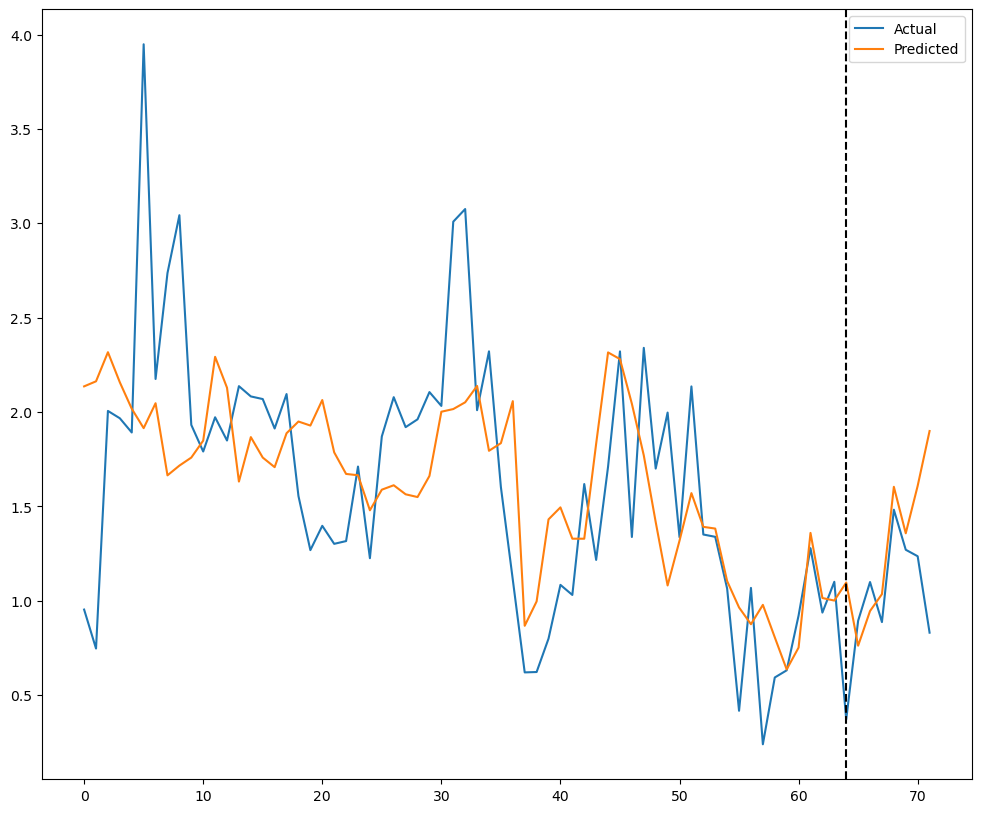

In [33]:
pred_in = results["pred_in_mean"] # In-sample (train)
pred_out = results["pred_mean"]   # OOS (test)

# Annualized in-sample
predict = np.concatenate((pred_in, pred_out), axis=0)
predict = DataTools.inverse_scaling(predict, y_mean, y_std) * 400

# Annualized OOS
real = np.concatenate((y_train, y_test), axis=0)
real = DataTools.inverse_scaling(real, y_mean, y_std) * 400

# Plot the results
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(real, label='Actual')
plt.plot(predict, label='Predicted')
plt.axvline(x=(oos_pos+1), color='black', linestyle='--')
plt.legend()
plt.show()

OOS RMSE : 0.3083802505948132


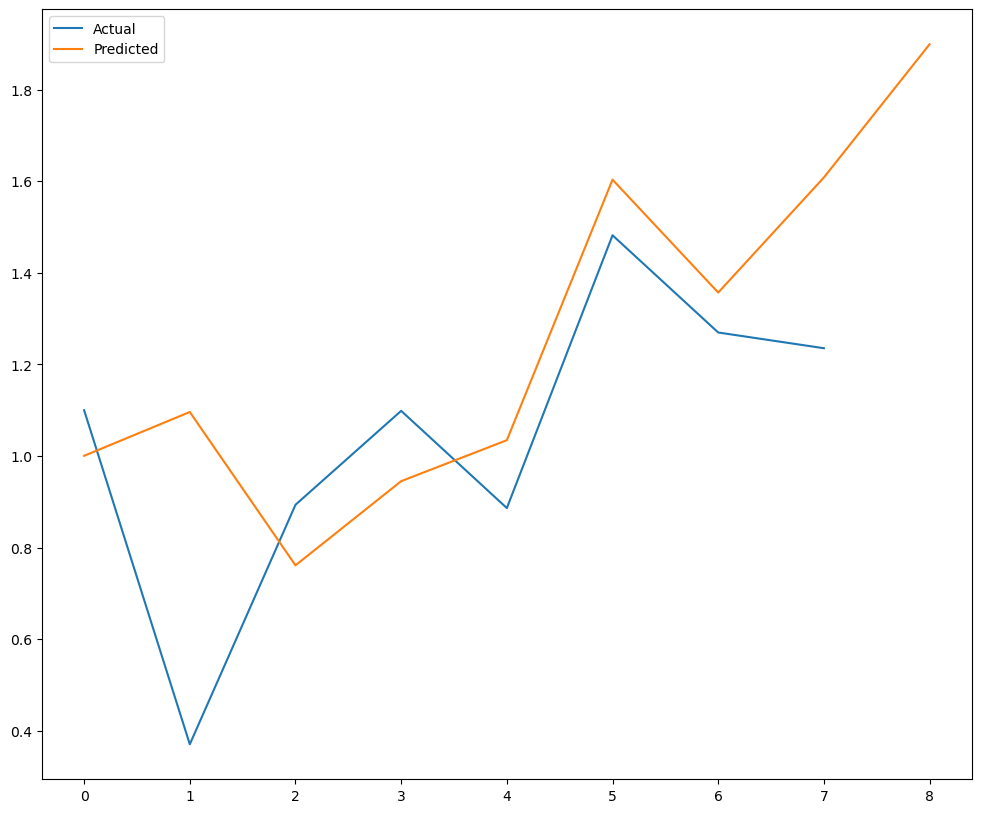

          Date  Realized  HNN2
66  2015-12-31       1.1   1.0
67  2016-03-31       0.4   1.1
68  2016-06-30       0.9   0.8
69  2016-09-30       1.1   0.9
70  2016-12-31       0.9   1.0
71  2017-03-31       1.5   1.6
72  2017-06-30       1.3   1.4
73  2017-09-30       1.2   1.6
74  2017-12-31       NaN   1.9


In [41]:
# Realized values
realized = y_test[:-1] # Remove the last value (2018Q1)
realized = np.append(realized, np.nan)
realized = DataTools.inverse_scaling(realized, y_mean, y_std) * 400

# Forecasted values
predicted = results["pred_mean"]
predicted = DataTools.inverse_scaling(predicted, y_mean, y_std) * 400

# Plot the results
print("OOS RMSE : " + str(math.sqrt(DataTools.MSE(realized, predicted)))) # RMSE
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(realized, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()

# Put realized and predicted values in a dataframe
df = pd.DataFrame({'Date':dates[-len(realized):],
                   'Realized': realized,
                   'HNN2': predicted})
df = df.round(1)
print(df)

In [42]:
df.to_csv('../data/predictions/HNN2.csv', index=False)

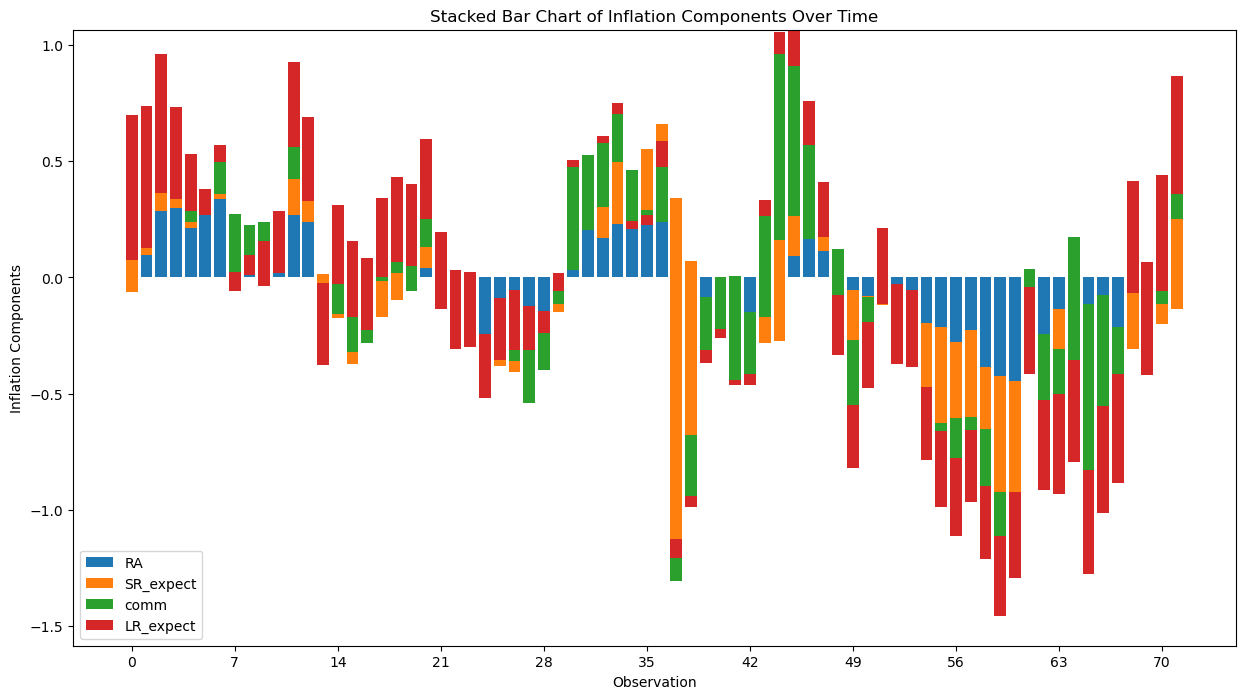

In [36]:
comps = np.vstack((results['part_pred_in_mean'], results['part_pred_mean']))

observations = len(comps)

components_names = ['RA', 'SR_expect', 'comm', 'LR_expect']

# Creating the stacked bar chart
plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Stacking bars for each component
bottom = np.zeros(observations)
for i in range(4):
    plt.bar(range(observations), comps[:, i], bottom=bottom, label=components_names[i])
    bottom += comps[:, i]

plt.xlabel('Observation')
plt.ylabel('Inflation Components')
plt.title('Stacked Bar Chart of Inflation Components Over Time')
plt.xticks(range(0, observations, max(1, observations // 10)))  # Adjust the x-axis ticks as needed
plt.legend()

plt.show()

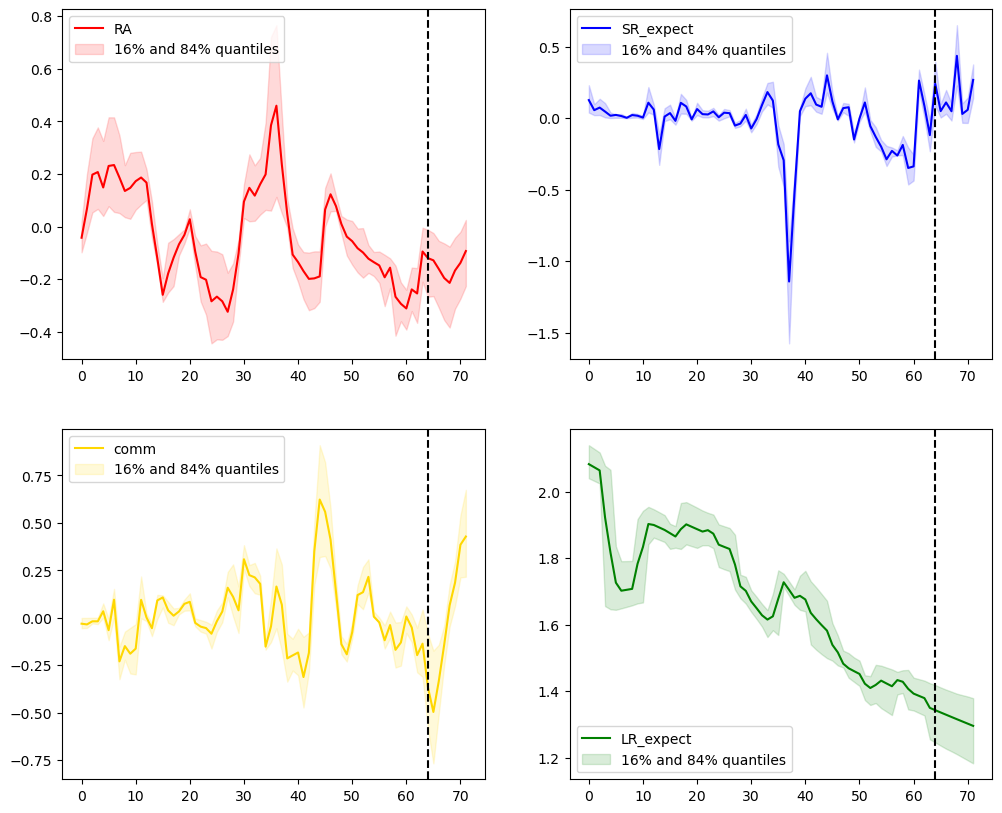

In [37]:
# Get all components
RA = np.concatenate((results['part_pred_in_mean'][:,0], results['part_pred_mean'][:,0]), axis=0)
RA = DataTools.inverse_scaling(RA, 0, y_std) * 400
RA_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,0,:],results["part_pred_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)
RA_quantiles = DataTools.inverse_scaling(RA_quantiles, 0, y_std) * 400


SR_expect = np.concatenate((results['part_pred_in_mean'][:,1], results['part_pred_mean'][:,1]), axis=0)
SR_expect = DataTools.inverse_scaling(SR_expect, 0, y_std) * 400
SR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,1,:],results["part_pred_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)
SR_expect_quantiles = DataTools.inverse_scaling(SR_expect_quantiles, 0, y_std) * 400

comm = np.concatenate((results['part_pred_in_mean'][:,2], results['part_pred_mean'][:,2]), axis=0)
comm = DataTools.inverse_scaling(comm, 0, y_std) * 400
comm_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,2,:],results["part_pred_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)
comm_quantiles = DataTools.inverse_scaling(comm_quantiles, 0, y_std) * 400

LR_expect = np.concatenate((results['part_pred_in_mean'][:,3], results['part_pred_mean'][:,3]), axis=0)
LR_expect = DataTools.inverse_scaling(LR_expect, y_mean, y_std) * 400
LR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,3,:],results["part_pred_ensemble"][:,3,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)
LR_expect_quantiles = DataTools.inverse_scaling(LR_expect_quantiles, y_mean, y_std) * 400

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')
axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')
axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')
axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')
axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.show()

### Gaps

In [134]:
gaps_list = np.vstack((results['gaps_in_mean'], results['gaps_mean']))
gaps_list = DataTools.inverse_scaling(gaps_list, 0, y_std) * 400
dates.reset_index(drop=True, inplace=True)
gaps_df = pd.DataFrame(gaps_list, columns=['RA', 'SR_expect', 'comm', 'LR_expect'])
gaps_df['Date'] = dates
gaps_df.set_index('Date', inplace=True)
gaps_df['OG_HNN'] = gaps_df['RA'] + gaps_df['SR_expect'] + gaps_df['comm'] + gaps_df['LR_expect']
gaps_df

,RA,SR_expect,comm,LR_expect,OG_HNN
Date,,,,,
2000-03-31,-0.197484,0.421089,-0.217613,0.433916,0.439908
2000-06-30,0.167033,0.192895,-0.193508,0.424535,0.590955
2000-09-30,0.608885,0.254372,-0.127795,0.415111,1.150573
2000-12-31,0.613716,0.232442,-0.054433,0.273416,1.065141
2001-03-31,0.478254,0.120337,0.086929,0.168189,0.853709
...,...,...,...,...,...
2016-12-31,-0.488883,0.099631,-0.220889,-0.325933,-0.936073
2017-03-31,-0.539757,0.817711,0.099536,-0.332662,0.044829
2017-06-30,-0.417242,0.049854,0.287153,-0.339356,-0.419591


In [135]:
gaps_df['OG'] = activity['OutputGap'][4:]
gaps_df

,RA,SR_expect,comm,LR_expect,OG_HNN,OG
Date,,,,,,
2000-03-31,-0.197484,0.421089,-0.217613,0.433916,0.439908,1.632900
2000-06-30,0.167033,0.192895,-0.193508,0.424535,0.590955,1.997100
2000-09-30,0.608885,0.254372,-0.127795,0.415111,1.150573,2.019100
2000-12-31,0.613716,0.232442,-0.054433,0.273416,1.065141,2.287100
2001-03-31,0.478254,0.120337,0.086929,0.168189,0.853709,2.636500
...,...,...,...,...,...,...
2016-12-31,-0.488883,0.099631,-0.220889,-0.325933,-0.936073,-1.323000
2017-03-31,-0.539757,0.817711,0.099536,-0.332662,0.044829,-1.022500
2017-06-30,-0.417242,0.049854,0.287153,-0.339356,-0.419591,-0.636670


#### HP Filtering

In [136]:
activity['RealGDP']

NaT                    NaN
1999-03-31    2.014397e+06
1999-06-30    2.027993e+06
1999-09-30    2.050443e+06
1999-12-31    2.076457e+06
                  ...     
2017-03-31    2.558857e+06
2017-06-30    2.577592e+06
2017-09-30    2.595178e+06
2017-12-31    2.610790e+06
2018-03-31             NaN
Name: RealGDP, Length: 78, dtype: float64

In [137]:
gaps_df['RealGDP'] = activity['RealGDP'][4:]
gaps_df

,RA,SR_expect,comm,LR_expect,OG_HNN,OG,RealGDP
Date,,,,,,,
2000-03-31,-0.197484,0.421089,-0.217613,0.433916,0.439908,1.632900,2.099829e+06
2000-06-30,0.167033,0.192895,-0.193508,0.424535,0.590955,1.997100,2.118578e+06
2000-09-30,0.608885,0.254372,-0.127795,0.415111,1.150573,2.019100,2.130083e+06
2000-12-31,0.613716,0.232442,-0.054433,0.273416,1.065141,2.287100,2.146567e+06
2001-03-31,0.478254,0.120337,0.086929,0.168189,0.853709,2.636500,2.164408e+06
...,...,...,...,...,...,...,...
2016-12-31,-0.488883,0.099631,-0.220889,-0.325933,-0.936073,-1.323000,2.542887e+06
2017-03-31,-0.539757,0.817711,0.099536,-0.332662,0.044829,-1.022500,2.558857e+06
2017-06-30,-0.417242,0.049854,0.287153,-0.339356,-0.419591,-0.636670,2.577592e+06


In [138]:
gaps_df['Log_RealGDP'] = np.log(gaps_df['RealGDP'])
gaps_df['LC_RealGDP'] = gaps_df['Log_RealGDP'].diff() *100
gaps_df = gaps_df.drop(columns=['Log_RealGDP', 'RealGDP'])
gaps_df = gaps_df[1:]
gaps_df

,RA,SR_expect,comm,LR_expect,OG_HNN,OG,LC_RealGDP
Date,,,,,,,
2000-06-30,0.167033,0.192895,-0.193508,0.424535,0.590955,1.997100,0.888920
2000-09-30,0.608885,0.254372,-0.127795,0.415111,1.150573,2.019100,0.541578
2000-12-31,0.613716,0.232442,-0.054433,0.273416,1.065141,2.287100,0.770915
2001-03-31,0.478254,0.120337,0.086929,0.168189,0.853709,2.636500,0.827688
2001-06-30,0.660409,0.271171,-0.177313,0.077626,0.831893,2.303600,0.161295
...,...,...,...,...,...,...,...
2016-12-31,-0.488883,0.099631,-0.220889,-0.325933,-0.936073,-1.323000,0.641987
2017-03-31,-0.539757,0.817711,0.099536,-0.332662,0.044829,-1.022500,0.626055
2017-06-30,-0.417242,0.049854,0.287153,-0.339356,-0.419591,-0.636670,0.729496


In [139]:
cycle, trend = sm.tsa.filters.hpfilter(gaps_df['LC_RealGDP'], lamb=1600)
cycle

Date
2000-06-30    0.377473
2000-09-30    0.045055
2000-12-31    0.289078
2001-03-31    0.360039
2001-06-30   -0.293112
                ...   
2016-12-31    0.074893
2017-03-31    0.029032
2017-06-30    0.102612
2017-09-30    0.023279
2017-12-31   -0.086588
Name: LC_RealGDP_cycle, Length: 71, dtype: float64

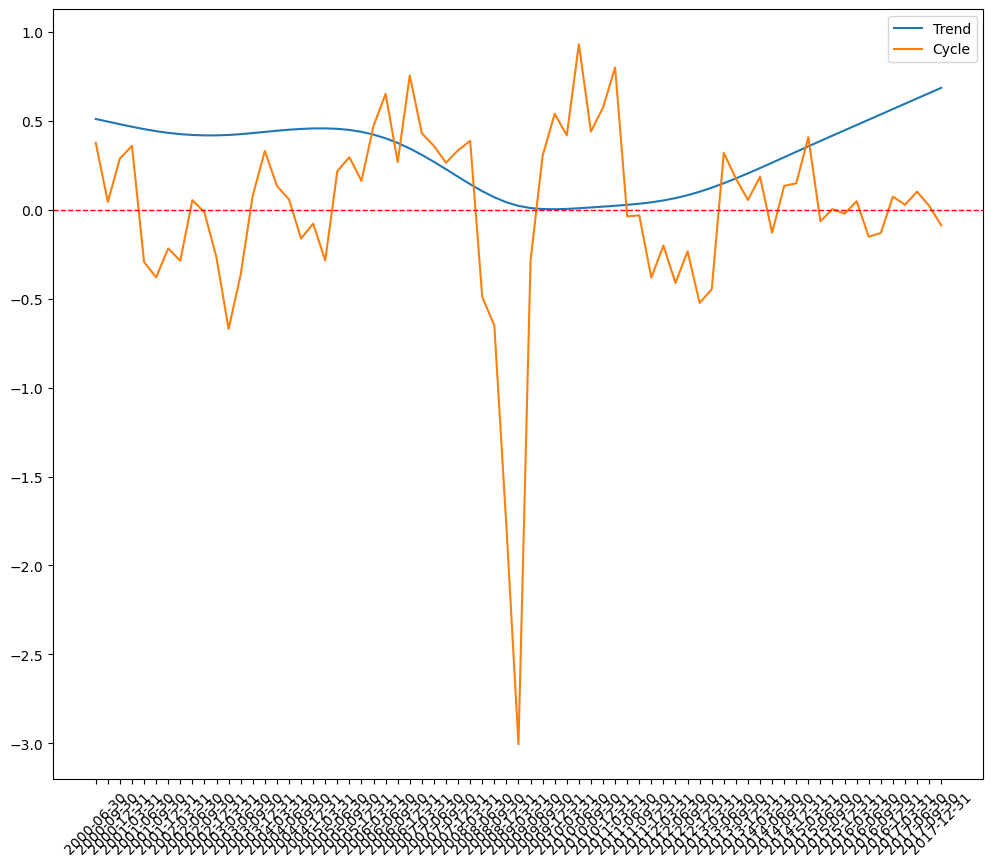

In [140]:
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(trend, label='Trend')
plt.plot(cycle, label='Cycle')
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Positive-Negative threshold')
plt.show()

In [141]:
gaps_df['Trend'] = trend
gaps_df['Cycle'] = cycle
gaps_df['OG_HP'] = gaps_df['LC_RealGDP'] - gaps_df['Trend']
gaps_df

,RA,SR_expect,comm,LR_expect,OG_HNN,OG,LC_RealGDP,Trend,Cycle,OG_HP
Date,,,,,,,,,,
2000-06-30,0.167033,0.192895,-0.193508,0.424535,0.590955,1.997100,0.888920,0.511447,0.377473,0.377473
2000-09-30,0.608885,0.254372,-0.127795,0.415111,1.150573,2.019100,0.541578,0.496524,0.045055,0.045055
2000-12-31,0.613716,0.232442,-0.054433,0.273416,1.065141,2.287100,0.770915,0.481836,0.289078,0.289078
2001-03-31,0.478254,0.120337,0.086929,0.168189,0.853709,2.636500,0.827688,0.467649,0.360039,0.360039
2001-06-30,0.660409,0.271171,-0.177313,0.077626,0.831893,2.303600,0.161295,0.454407,-0.293112,-0.293112
...,...,...,...,...,...,...,...,...,...,...
2016-12-31,-0.488883,0.099631,-0.220889,-0.325933,-0.936073,-1.323000,0.641987,0.567094,0.074893,0.074893
2017-03-31,-0.539757,0.817711,0.099536,-0.332662,0.044829,-1.022500,0.626055,0.597024,0.029032,0.029032
2017-06-30,-0.417242,0.049854,0.287153,-0.339356,-0.419591,-0.636670,0.729496,0.626884,0.102612,0.102612


In [142]:
gaps_df['Cycle_exp'] = np.exp(cycle)
gaps_df

,RA,SR_expect,comm,LR_expect,OG_HNN,OG,LC_RealGDP,Trend,Cycle,OG_HP,Cycle_exp
Date,,,,,,,,,,,
2000-06-30,0.167033,0.192895,-0.193508,0.424535,0.590955,1.997100,0.888920,0.511447,0.377473,0.377473,1.458595
2000-09-30,0.608885,0.254372,-0.127795,0.415111,1.150573,2.019100,0.541578,0.496524,0.045055,0.045055,1.046085
2000-12-31,0.613716,0.232442,-0.054433,0.273416,1.065141,2.287100,0.770915,0.481836,0.289078,0.289078,1.335196
2001-03-31,0.478254,0.120337,0.086929,0.168189,0.853709,2.636500,0.827688,0.467649,0.360039,0.360039,1.433385
2001-06-30,0.660409,0.271171,-0.177313,0.077626,0.831893,2.303600,0.161295,0.454407,-0.293112,-0.293112,0.745938
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,-0.488883,0.099631,-0.220889,-0.325933,-0.936073,-1.323000,0.641987,0.567094,0.074893,0.074893,1.077769
2017-03-31,-0.539757,0.817711,0.099536,-0.332662,0.044829,-1.022500,0.626055,0.597024,0.029032,0.029032,1.029457
2017-06-30,-0.417242,0.049854,0.287153,-0.339356,-0.419591,-0.636670,0.729496,0.626884,0.102612,0.102612,1.108061


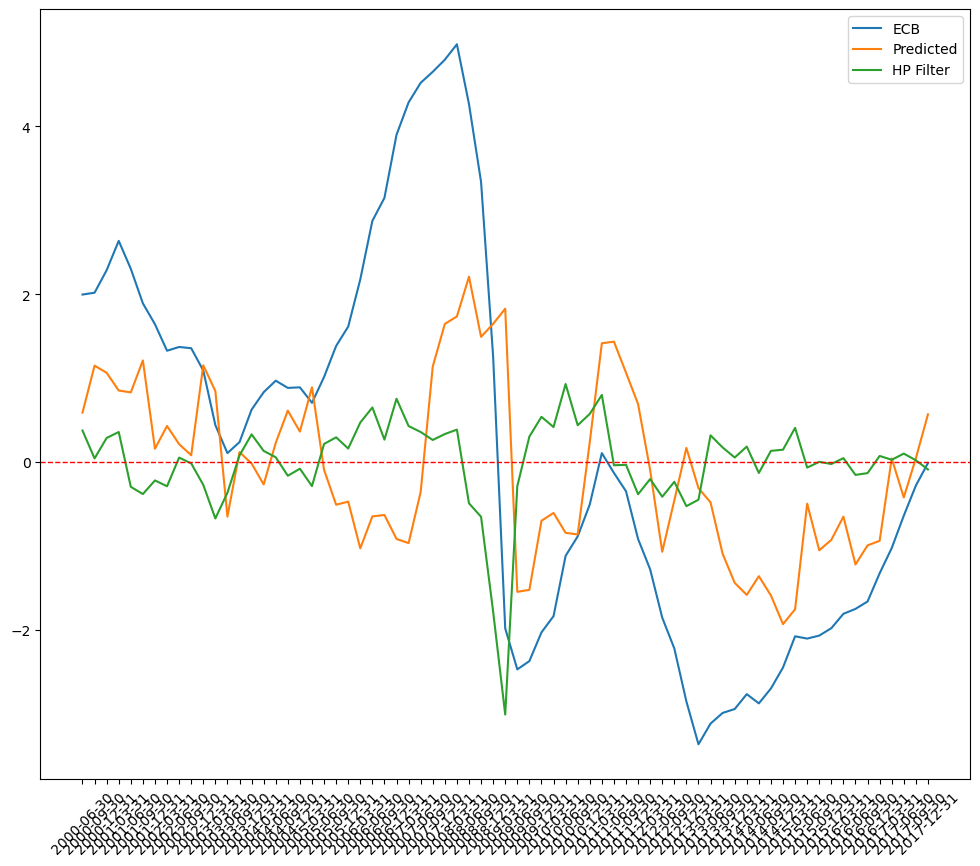

In [144]:
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(gaps_df['OG'], label='ECB')
plt.plot(gaps_df['OG_HNN'], label='Predicted')
plt.plot(gaps_df['OG_HP'], label='HP Filter')
# plt.plot(gaps_df['Cycle_exp'], label='HP Filter %')
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Positive-Negative threshold')
plt.show()

In [145]:
gaps_df.to_csv('../data/processed/hnn2_gaps.csv', index=True)

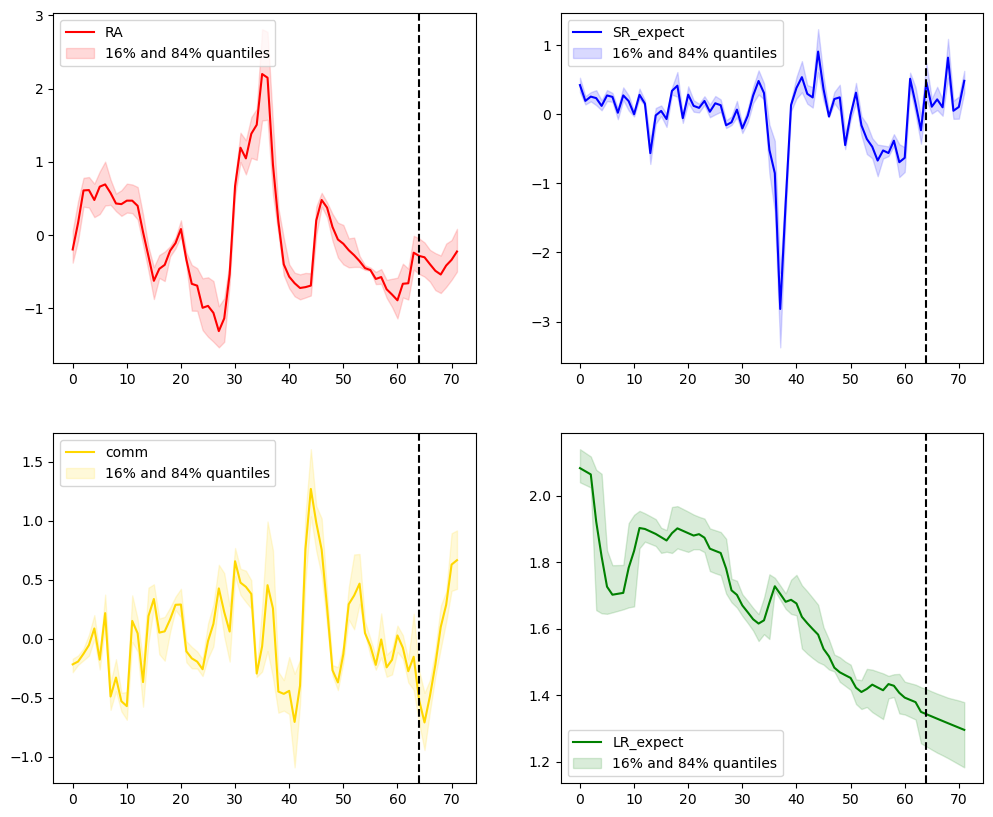

In [38]:
# Get all gaps
RA = np.concatenate((results['gaps_in_mean'][:,0], results['gaps_mean'][:,0]), axis=0)
RA = DataTools.inverse_scaling(RA, 0, y_std) * 400
RA_quantiles = np.concatenate((results["gaps_in_ensemble"][:,0,:],results["gaps_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)
RA_quantiles = DataTools.inverse_scaling(RA_quantiles, 0, y_std) * 400

SR_expect = np.concatenate((results['gaps_in_mean'][:,1], results['gaps_mean'][:,1]), axis=0)
SR_expect = DataTools.inverse_scaling(SR_expect, 0, y_std) * 400
SR_expect_quantiles = np.concatenate((results["gaps_in_ensemble"][:,1,:],results["gaps_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)
SR_expect_quantiles = DataTools.inverse_scaling(SR_expect_quantiles, 0, y_std) * 400

comm = np.concatenate((results['gaps_in_mean'][:,2], results['gaps_mean'][:,2]), axis=0)
comm = DataTools.inverse_scaling(comm, 0, y_std) * 400
comm_quantiles = np.concatenate((results["gaps_in_ensemble"][:,2,:],results["gaps_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)
comm_quantiles = DataTools.inverse_scaling(comm_quantiles, 0, y_std) * 400

LR_expect = np.concatenate((results['gaps_in_mean'][:,3], results['gaps_mean'][:,3]), axis=0)
LR_expect = DataTools.inverse_scaling(LR_expect, y_mean, y_std) * 400
LR_expect_quantiles = np.concatenate((results["gaps_in_ensemble"][:,3,:],results["gaps_ensemble"][:,3,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)
LR_expect_quantiles = DataTools.inverse_scaling(LR_expect_quantiles, y_mean, y_std) * 400

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')
axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')
axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')
axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')
axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.show()

## Trends (Time-varying coefficients)

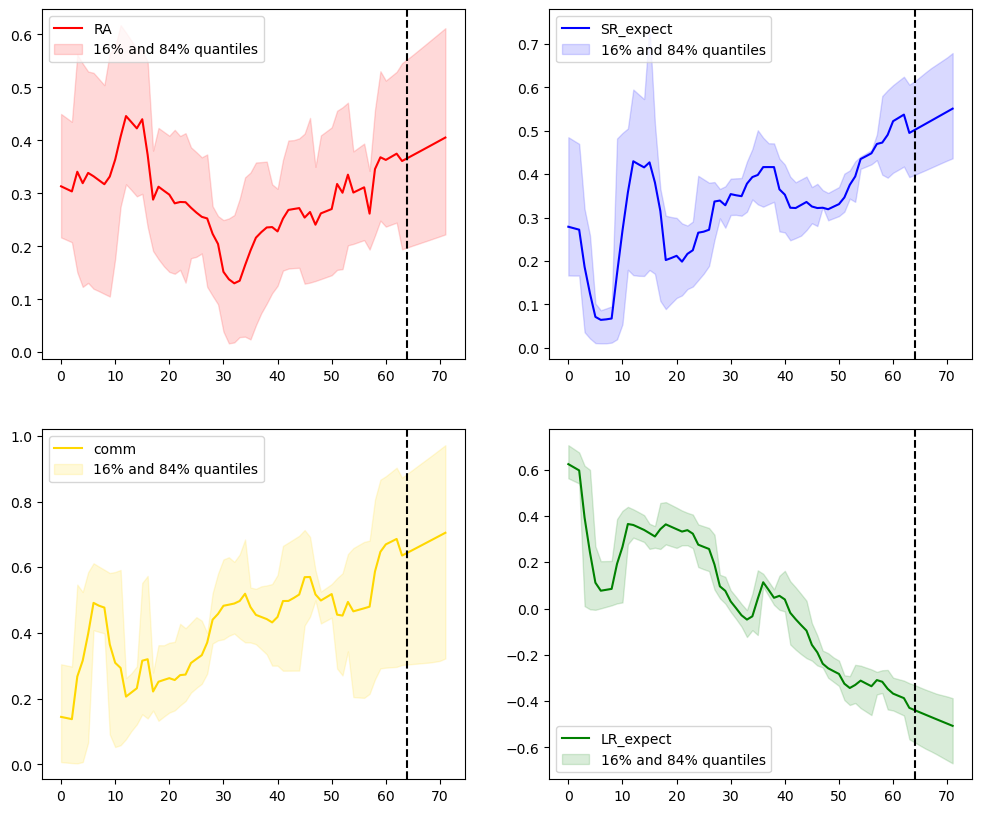

In [39]:
RA = np.concatenate((results['trends_in_mean'][:,0], results['trends_mean'][:,0]), axis=0)
RA_quantiles =  np.concatenate((results["trends_in_ensemble"][:,0,:],results["trends_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)

SR_expect = np.concatenate((results['trends_in_mean'][:,1], results['trends_mean'][:,1]), axis=0)
SR_expect_quantiles = np.concatenate((results["trends_in_ensemble"][:,1,:],results["trends_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)

comm = np.concatenate((results['trends_in_mean'][:,2], results['trends_mean'][:,2]), axis=0)
comm_quantiles = np.concatenate((results["trends_in_ensemble"][:,2,:],results["trends_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)

LR_expect = np.concatenate((results['part_pred_in_mean'][:,3], results['part_pred_mean'][:,3]), axis=0)
LR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,3,:],results["part_pred_ensemble"][:,3,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')
axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')
axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')
axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')
axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.show()

In [40]:
# save model
torch.save(results, '../models/HNN2.pt')